In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.utils as utils

import copy
import os

- Usage GPU / CPU
- Import du modèle VGG-19, avec récupération des layers désirés dont convolutional layers conv1_1, conv2_1, conv3_1, conv4_1, conv5_1 après maxpooling

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [40]:
# model = models.vgg19(weights='VGG19_Weights.DEFAULT').features[:29].to(device).eval() # pour geler les poids du NN
# print(model) # pour récupérer les couches du modèle et leur numéro respectif

class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()

        self.kept_content_features = [28] # conv4_2
        self.kept_style_features = [0, 5, 10, 19, 28] # conv1_1, conv2_1, conv3_1, conv4_1, conv5_1
        self.model = models.vgg19(weights='VGG19_Weights.DEFAULT').features[:29]
    
    def forward(self, x):
        content_activations = []
        style_activations = []

        for layer_num, layer in enumerate(self.model): # pour chaque layer du modèle
            x = layer(x) # on fait passer x par ce layer

            if layer_num in self.kept_content_features: # et si ce layer est un des convolutional layers qui nous intéressent pour le content
                content_activations.append(x) # stocker ses activations
            
            if layer_num in self.kept_style_features: # et si ce layer est un des convolutional layers qui nous intéressent pour le content
                style_activations.append(x) # stocker ses activations
        
        return content_activations, style_activations

model = VGG().to(device).eval() # pour geler les poids du NN

- Loading des images, avec resize puis transformation vers tensors pour la computation
- Unloading des tensors, avec dé-transformation vers images pour l'affichage
- Plots

Available images in 'images/' : {0: 'Eiffel_tower_content.jpg', 1: 'cat_content.jpg', 2: 'voiture4x4_content.jpg', 3: 'dancing_content.jpg', 4: 'van_gogh_style.jpg', 5: 'brigitte_content.jpg', 6: 'picasso_2_style.jpg', 7: 'lion_content.jpg', 8: 'vague_fuji_style.jpg', 9: 'flou_style.jpg', 10: 'contemp_style.jpg', 11: 'picasso_style.jpg', 12: 'fleur_style.jpg'}

index of content image : 2
index of style image : 9

content_img.size() : torch.Size([1, 3, 256, 256]) --- style_img.size() : torch.Size([1, 3, 256, 256])



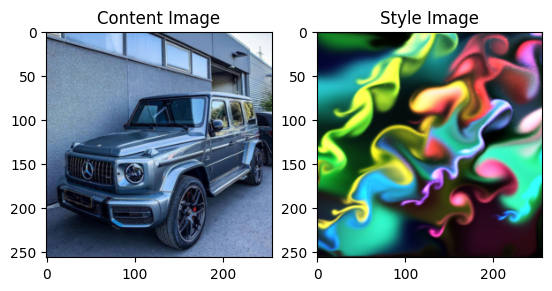

In [55]:
def image_loader(image_name, imsize):

    loader = transforms.Compose([
                                 transforms.Resize(imsize),
                                 transforms.CenterCrop((imsize, imsize)),  # Recadrage carré
                                 transforms.ToTensor()])
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0) # ajout d'une dimension de batch
    return image.to(device, torch.float)

def imshow(tensor, title=None):

    unloader = transforms.ToPILImage()
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

def image_import(image_directory = "images/"):

    available_images_list = filter(lambda x : x.endswith('.jpg') or x.endswith('.png'),
                                   os.listdir(image_directory))
    available_images_dict = {k:v for k,v in enumerate(available_images_list)} # + agréable si beaucoup d'images

    print(f"Available images in '{image_directory}' : {available_images_dict}\n")
    idx_content = int(input("index of content image : "))
    idx_style = int(input("index of style image : "))
    print()
    assert idx_content != idx_style, "choisir une images style différente de l'image content"

    imsize = 256 if torch.cuda.is_available() else 256
    content_img = image_loader(image_directory + available_images_dict[idx_content], imsize)
    style_img = image_loader(image_directory + available_images_dict[idx_style], imsize)

    return content_img, style_img

content_img, style_img = image_import()

#generated_img = torch.randn(content_img.data.size(), device=device).requires_grad_(True)
generated_img = content_img.clone().requires_grad_(True) # (1)(2)(3)
# (1) initialement, l'image à générer est bruitée (ou bien la même que la content image)
# (2) on aurait pu commencer avec une image avec du bruit
# (3) requires_grad_(True) car c'est l'image qu'on veut modifier au cours de l'entraînement


print(f"content_img.size() : {content_img.size()} --- style_img.size() : {style_img.size()}\n")
assert content_img.size() == style_img.size(), "les images doivent avoir les mêmes dimensions"

plt.figure()
plt.subplot(1,2,1) ; imshow(content_img, title='Content Image')
plt.subplot(1,2,2) ; imshow(style_img, title='Style Image')

# content : https://pulpbits.net/wp-content/uploads/2014/01/Maine-Coon-Cats.jpg
# style : https://www.publicdomainpictures.net/pictures/240000/velka/abstract-painting-1.jpg

In [56]:
generated_img = content_img.clone().requires_grad_(True) # (1)(2)(3)
#generated_img = torch.randn(content_img.data.size(), device=device).requires_grad_(True)


In [ ]:
def get_content_loss(C,G):
    return 1/2 * F.mse_loss(C, G, reduction='sum') # calcule la MSELoss (https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss)

def gram_matrix(x):
    B, C, H, W = x.shape # |batch|, |channels|, height, width
    N, M = B*C, H*W
    activations = x.reshape(N,M) # page 10

    gram = torch.mm(activations, activations.t())
    return gram, N, M

def get_style_loss(S,G,w_coefficient=True):
    gram_S, N, M = gram_matrix(S)
    gram_G = gram_matrix(G)[0]

    return (1)*(w_coefficient) * 1/(2*N*M)**2 * F.mse_loss(gram_S, gram_G, reduction='sum')

#alpha, beta = 0.000000008, 100000000000
#alpha, beta = 0.5, 5000000000
alpha, beta = 1, 5000000


optimizer = optim.LBFGS([generated_img])

epochs = 600
for epoch in range(epochs):

    def closure():

        optimizer.zero_grad()
        content_loss, style_loss = 0,0

        # Donner chaque image au NN et récupérer les activations souhaitées
        content_activations = model(content_img)[0]
        style_activations = model(style_img)[1]
        generated_content_activations, generated_style_activations = model(generated_img)
        

        #Wheight haut donne moins de detail dans le style 
        #WHeight bas donne plus de détail dans le style 
        wheight = 0.8
        for content_activation, generated_content_activation in zip(content_activations, generated_content_activations):
          
          content_loss += get_content_loss(content_activation, generated_content_activation)
          
        for style_activation, generated_style_activation in zip(style_activations, generated_style_activations):

          style_loss += wheight * get_style_loss(style_activation, generated_style_activation)
          if wheight >= 0.25 : wheight = wheight *0.5
        loss = alpha*content_loss + beta*style_loss
        loss.backward()

        if epoch % 10 == 0:
            print(f"epoch {epoch} :")
            print(f"Content Loss : {content_loss}")
            print(f"Style Loss : {style_loss}")
            print("-"*25)

            utils.save_image(generated_img, f'generated_{epoch}.jpg')

        return loss

    optimizer.step(closure)

utils.save_image(generated_img, f'generated_final.jpg')

epoch 0 :
Content Loss : 0.0
Style Loss : 13.513480186462402
-------------------------
epoch 0 :
Content Loss : 1.4506022930145264
Style Loss : 13.473211288452148
-------------------------
epoch 0 :
Content Loss : 288645.375
Style Loss : 4.043100357055664
-------------------------
epoch 0 :
Content Loss : 378029.5
Style Loss : 3.35013484954834
-------------------------
epoch 0 :
Content Loss : 534518.625
Style Loss : 2.6277613639831543
-------------------------
epoch 0 :
Content Loss : 666243.1875
Style Loss : 1.9669331312179565
-------------------------
epoch 0 :
Content Loss : 870855.6875
Style Loss : 1.426754117012024
-------------------------
epoch 0 :
Content Loss : 985941.8125
Style Loss : 1.123402714729309
-------------------------
epoch 0 :
Content Loss : 1013492.75
Style Loss : 0.9792520999908447
-------------------------
epoch 0 :
Content Loss : 1069209.75
Style Loss : 0.8212376832962036
-------------------------
epoch 0 :
Content Loss : 1112982.375
Style Loss : 0.65942573547

In [ ]:
# Cafe terrace
# https://ae01.alicdn.com/kf/HTB12lNTNXXXXXcYaXXXq6xXFXXX4/Cafe-Terrace-At-Night-by-Vincent-Van-Gogh-Wall-Canvas-Prints-Oil-Painting-Reproductions-Street-Scenes.jpg

In [ ]:
# content
# https://fr.web.img6.acsta.net/c_300_300/pictures/18/09/13/10/49/0567834.jpg